##Importing Libraries and Dataset


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/MyDrive/all_diseases/train_val'
data_dir = pathlib.Path(data_dir).with_suffix('')

##Image Visualization

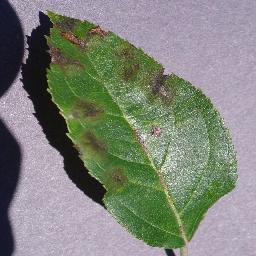

In [ ]:
apple_black_rot = list(data_dir.glob('Apple - Apple Scab/*'))
PIL.Image.open(str(apple_black_rot[0]))

##Define Certain Parameters

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

##Train:Val Split (80:20)

In [ ]:
#train DS
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#val DS
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8590 files belonging to 43 classes.
Using 6872 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8590 files belonging to 43 classes.
Using 1718 files for validation.


## Visualize Some Image Data

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Apple - Apple Scab', 'Apple - Black Rot', 'Apple - Cedar Apple Rust', 'Bell Pepper - Bacterial Spot', 'Cherry - Powdery Mildew', 'Corn - Common Rust', 'Corn - Corn Cercospora leaf spot (Gray leaf spot)', 'Corn - Northern Leaf Blight', 'Grape - Black Rot', 'Grape - Esca (Black Measles)', 'Grape Leaf Blight (Isariopsis Leaf Spot)', 'Mango - Anthracnose', 'Mango - Bacterial Canker', 'Mango - Cutting Weevil', 'Mango - Die Back', 'Mango - Gall Midge', 'Mango - Powdery Mildew', 'Mango - Sooty Mould', 'Orange - Haunglongbing (Citrus greening)', 'Peach - Bacterial Spot', 'Potato - Bacteria', 'Potato - Early Blight', 'Potato - Fungi', 'Potato - Late Blight', 'Potato - Nematode', 'Potato - Pest', 'Potato - Phytopthora', 'Potato - Virus', 'Rose - Black Spot', 'Rose - Downy Mildew', 'Squash - Powdery Mildew', 'Strawberry - Lead Scorch', 'Synthetic - Fire Blight', 'Synthetic - Healthy', 'Tomato - Bacterial Spot', 'Tomato - Early Blight', 'Tomato - Late Blight', 'Tomato - Leaf Mold', 'Tomato - Mos

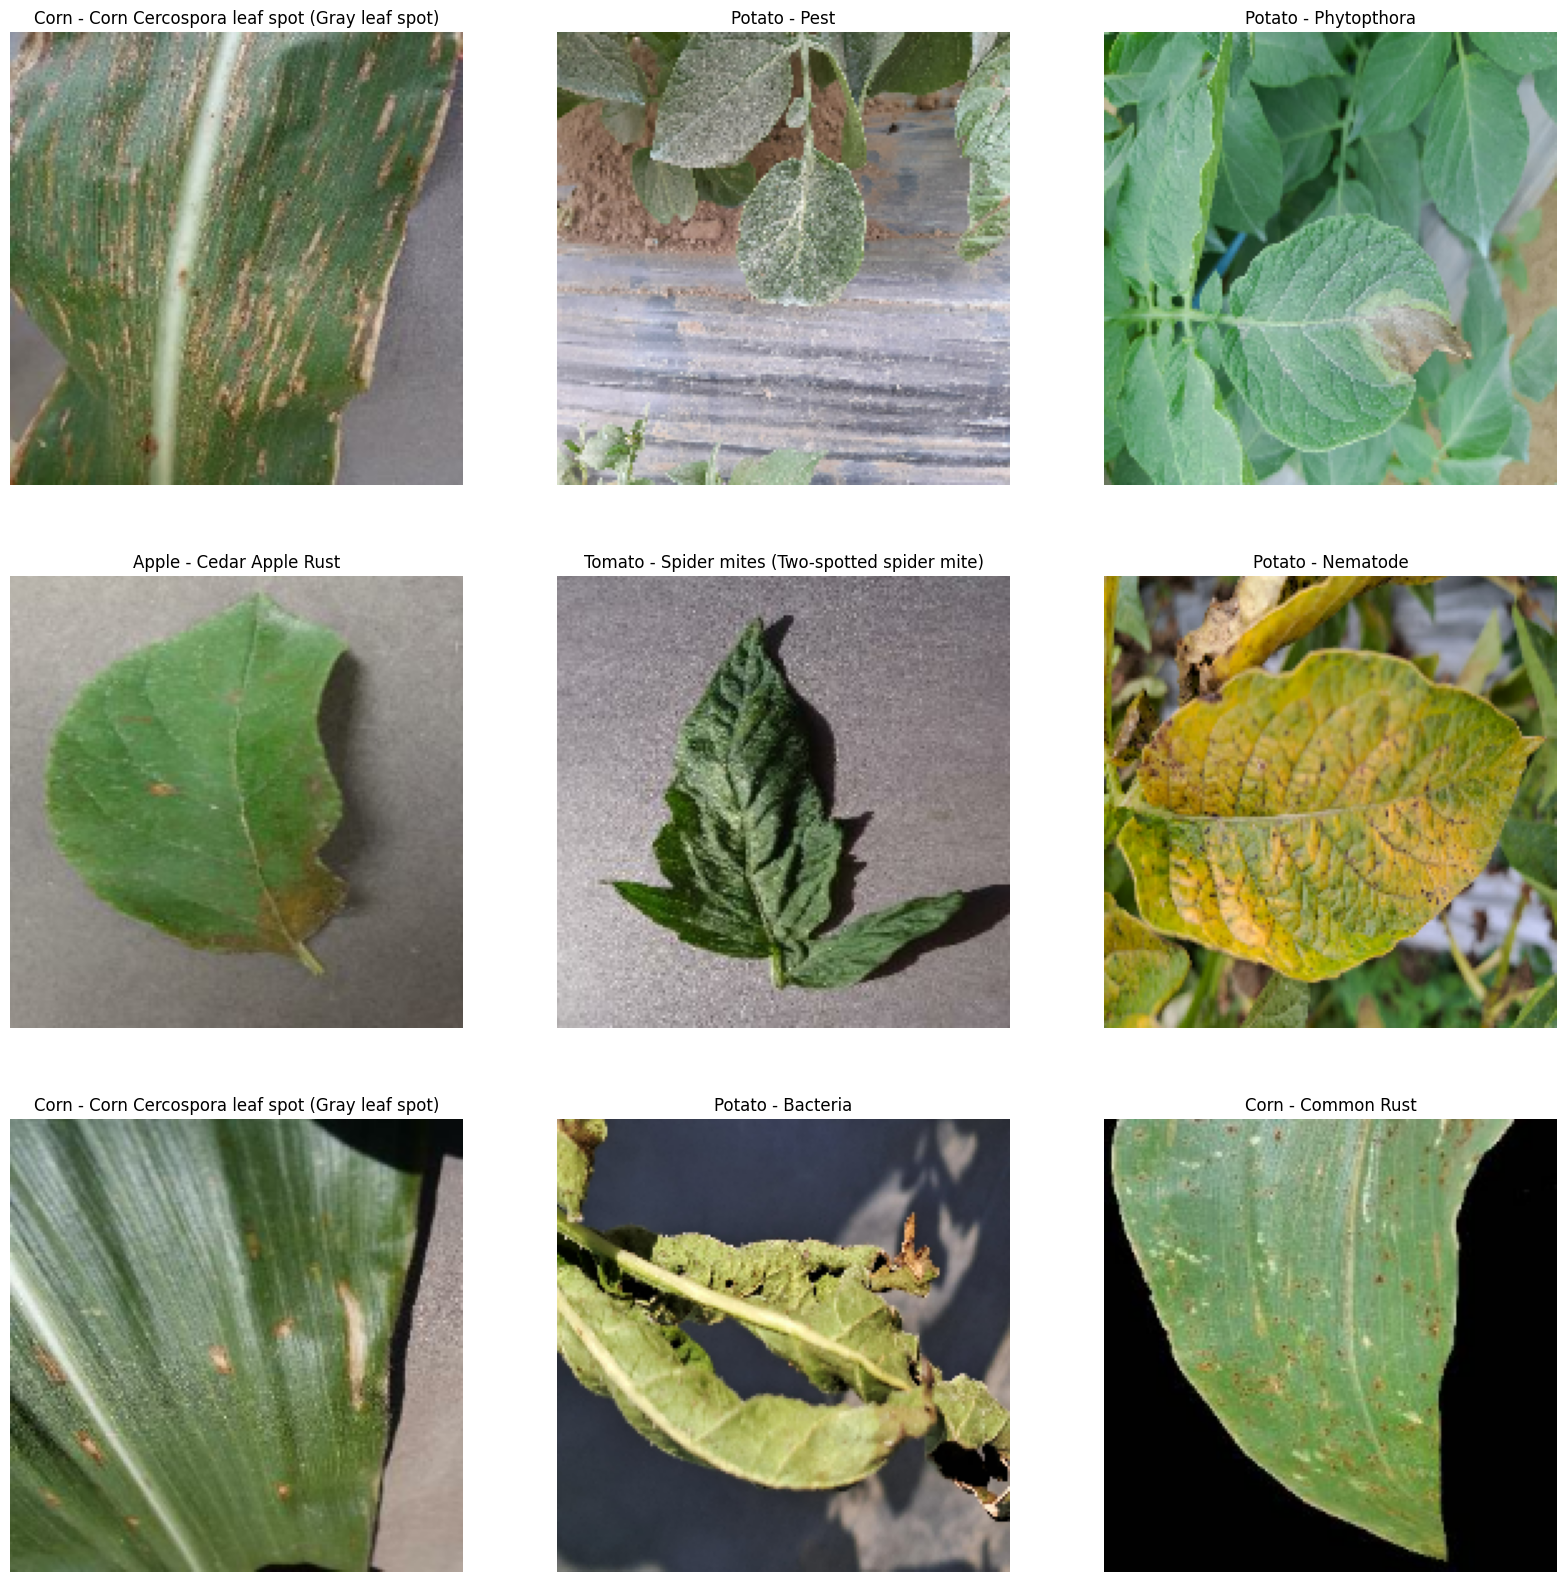

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ])

##Visualize Augmented Data

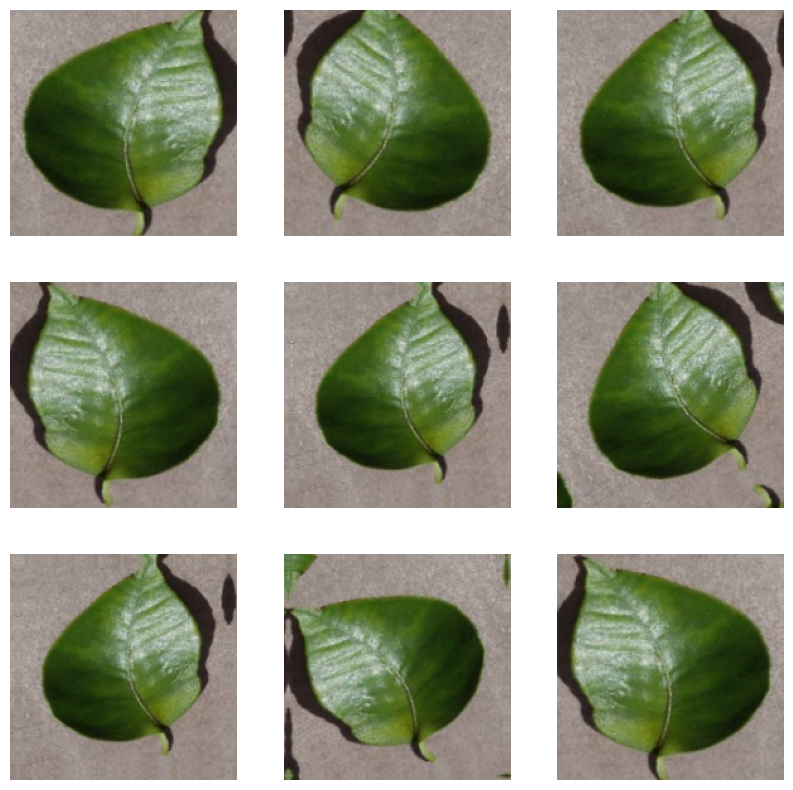

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

##Configure Dataset Performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize Data

In [ ]:
normalization_layer = layers.Rescaling(1./255)

## Tensorflow Keras Sequential Model Architecture



In [ ]:
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and Train

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
#disease classification
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs)

Epoch 1/60
215/215 [==============================] - 9s 29ms/step - loss: 0.1578 - accuracy: 0.9457 - val_loss: 0.6148 - val_accuracy: 0.8568
Epoch 2/60
215/215 [==============================] - 6s 29ms/step - loss: 0.1464 - accuracy: 0.9502 - val_loss: 0.7493 - val_accuracy: 0.8388
Epoch 3/60
215/215 [==============================] - 6s 29ms/step - loss: 0.1472 - accuracy: 0.9501 - val_loss: 0.9079 - val_accuracy: 0.8137
Epoch 4/60
215/215 [==============================] - 6s 28ms/step - loss: 0.1707 - accuracy: 0.9409 - val_loss: 0.7444 - val_accuracy: 0.8388
Epoch 5/60
215/215 [==============================] - 6s 29ms/step - loss: 0.1292 - accuracy: 0.9566 - val_loss: 0.8272 - val_accuracy: 0.8254
Epoch 6/60
215/215 [==============================] - 6s 29ms/step - loss: 0.1424 - accuracy: 0.9517 - val_loss: 0.8334 - val_accuracy: 0.8155
Epoch 7/60
215/215 [==============================] - 6s 28ms/step - loss: 0.1517 - accuracy: 0.9491 - val_loss: 0.9819 - val_accuracy: 0.8038

## Visualize Train Results

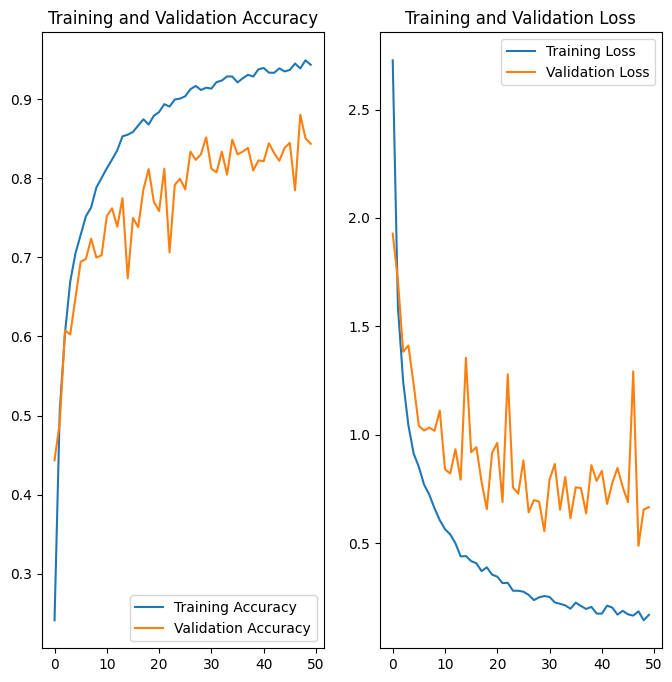

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Save Model

In [ ]:
model.save('disease_detection.keras')

# Predict on Test Data

##Load Model in

In [ ]:
model = tf.keras.models.load_model('disease_detection.keras')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

##Predict

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
import os

detection = "/content/drive/MyDrive/all_diseases/Test/"
detectionList = os.listdir(detection)
for condition in detectionList:
  print(condition)
  print("---------")
  conditionList = os.listdir(detection+condition)
  for item in conditionList:
    img = tf.keras.utils.load_img(detection+condition+"/"+item, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
TestApple___Black_rot
---------
1/1 [==============================] - 0s 311ms/step
This image most likely belongs to Apple - Black Rot with a 85.36 percent confidence.
1/1 [==============================] - 0s 18ms/step
This image most likely belongs to Apple - Black Rot with a 100.00 percent confidence.
1/1 [==============================] - 0s 27ms/step
This image most likely belongs to Apple - Black Rot with a 100.00 percent confidence.
1/1 [==============================] - 0s 20ms/step
This image most likely belongs to Apple - Black Rot with a 99.82 percent confidence.
1/1 [==============================] - 0s 19ms/step
This image most likely belongs to Apple - Black Rot with a 99.72 percent confidence.
1/1 [==============================] - 0s 17ms/step
This image most likely belongs to Apple - Black Rot with a 99.87 percent confidence.
1/1 [=======